In [1]:
from astrometry.util.fits import *
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.libkd.spherematch import *
import json
from astrometry.util.util import Tan, Sip, fit_sip_wcs_py
from astrometry.util.starutil_numpy import radectoxyz, arcsec_between
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
%load_ext autoreload
%aimport petal_metrology
%aimport platescale_ss

In [3]:
from platescale_ss import Tpsfunc, Rps, Mps, Sps, Tps
from petal_metrology import get_petal

In [4]:
petal_id = 10

In [5]:
petal = get_petal(petal_id)

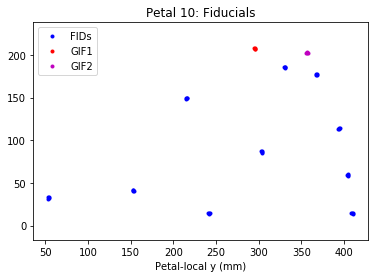

In [6]:
plt.plot(petal.fifs.x.ravel(), petal.fifs.y.ravel(), 'b.', label='FIDs')
plt.plot(petal.gif1.x, petal.gif1.y, 'r.', label='GIF1')
plt.plot(petal.gif2.x, petal.gif2.y, 'm.', label='GIF2')
plt.legend()
plt.title('Petal %i: Fiducials' % petal_id)
plt.xlabel('Petal-local x (mm)')
plt.xlabel('Petal-local y (mm)')
plt.axis('equal');

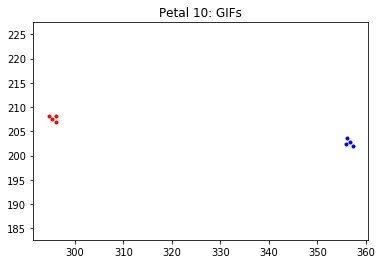

In [7]:
plt.plot(petal.gif1.x, petal.gif1.y, 'r.')
plt.plot(petal.gif2.x, petal.gif2.y, 'b.')
plt.title('Petal %i: GIFs' % petal_id)
plt.axis('equal');

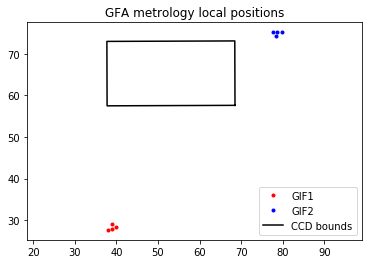

In [8]:
plt.plot(petal.gfa.gif_1_mm_x, petal.gfa.gif_1_mm_y, 'r.', label='GIF1')
plt.plot(petal.gfa.gif_2_mm_x, petal.gfa.gif_2_mm_y, 'b.', label='GIF2')
cx,cy = petal.gfa_pix_to_gfa_mm(petal.ccdbpx, petal.ccdbpy)
plt.plot(cx, cy, 'k-', label='CCD bounds')
plt.legend()
plt.title('GFA metrology local positions')
plt.axis('equal');

In [9]:
g1x,g1y = petal.gfa_mm_to_focal_mm(petal.gfa.gif_1_mm_x, petal.gfa.gif_1_mm_y)
g2x,g2y = petal.gfa_mm_to_focal_mm(petal.gfa.gif_2_mm_x, petal.gfa.gif_2_mm_y)

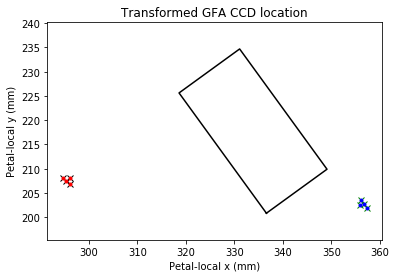

In [10]:
plt.plot(petal.ccdbx, petal.ccdby, 'k-')
plt.plot(g1x, g1y, 'kx')
plt.plot(petal.gif1.x, petal.gif1.y, 'r.')
plt.plot(g2x, g2y, 'gx')
plt.plot(petal.gif2.x, petal.gif2.y, 'b.')
plt.title('Transformed GFA CCD location')
plt.xlabel('Petal-local x (mm)')
plt.ylabel('Petal-local y (mm)')
plt.axis('equal');

In [11]:
print('Scatter in GIF1 fit positions: %.3f mm' % (np.mean(np.hypot(petal.gif1.x - g1x, petal.gif1.y - g1y))))
print('Scatter in GIF2 fit positions: %.3f mm' % (np.mean(np.hypot(petal.gif2.x - g2x, petal.gif2.y - g2y))))

Scatter in GIF1 fit positions: 0.004 mm
Scatter in GIF2 fit positions: 0.006 mm


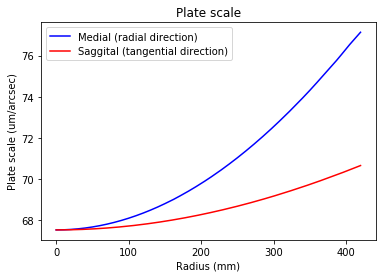

In [12]:
plt.plot(Rps, Mps, 'b-', label='Medial (radial direction)')
plt.plot(Rps, Sps, 'r-', label='Saggital (tangential direction)')
plt.legend()
plt.xlabel('Radius (mm)')
plt.title('Plate scale')
plt.ylabel('Plate scale (um/arcsec)');

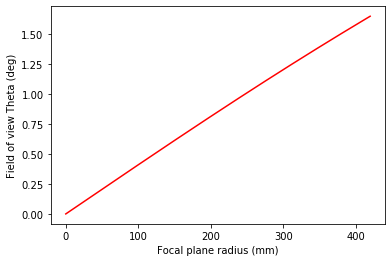

In [13]:
plt.plot(Rps, Tps, 'r-')
plt.xlabel('Focal plane radius (mm)')
plt.ylabel('Field of view Theta (deg)');

Now fit a SIP polynomial distortion model for how the echo22 optics projects onto GFA CCD pixels.

Evaluate a grid of points in CCD space and in RA,Dec, using the metrology transformations to go from GFA CCD pixels
to focal plane coordinates, and from there to Theta and RA,Dec.

In [14]:
petal.gfa.gif_1_pix_y

array([-1899.8263, -1987.4465, -1945.6589, -1966.752 ], dtype=float32)

In [15]:
x0 = min(min(petal.gfa.gif_1_pix_x), min(petal.gfa.gif_2_pix_x)) - 100
y0 = min(min(petal.gfa.gif_1_pix_y), min(petal.gfa.gif_2_pix_y)) - 100
x1 = petal.ccdw + 100
y1 = petal.ccdh + 100

ccdgridpx, ccdgridpy = np.meshgrid(np.linspace(x0, x1, 20), np.linspace(y0, y1, 20))
ccdgridpx = ccdgridpx.ravel()
ccdgridpy = ccdgridpy.ravel()
gridx, gridy = petal.gfa_pix_to_focal_mm(ccdgridpx, ccdgridpy)
gridr = np.hypot(gridx, gridy)
crpixx,crpixy = (petal.ccdw+1.)/2., (petal.ccdh+1.)/2.
crx,cry = petal.gfa_pix_to_focal_mm(crpixx, crpixy)

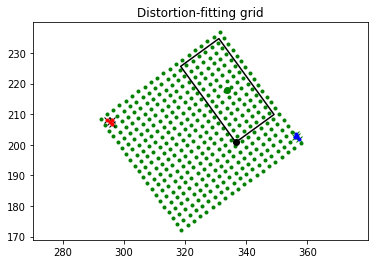

In [18]:
plt.plot(gridx, gridy, 'g.')
plt.plot(crx, cry, 'go')

plt.plot(petal.ccdbx, petal.ccdby, 'k-')
plt.plot(petal.ccdbx[0], petal.ccdby[0], 'ko')
plt.plot(g1x, g1y, 'kx')
plt.plot(petal.gif1.x, petal.gif1.y, 'r.')
plt.plot(g2x, g2y, 'gx')
plt.plot(petal.gif2.x, petal.gif2.y, 'b.')
plt.title('Distortion-fitting grid')
plt.axis('equal');

In [19]:
theta = Tpsfunc(gridr)
gridu = theta * gridx / gridr
gridv = theta * gridy / gridr
crr = np.hypot(crx, cry)
crd = Tpsfunc(crr)
cru = crd * crx / crr
crv = crd * cry / crr

In [21]:
griddec = gridv
gridra  = gridu / np.cos(np.deg2rad(griddec))
starxyz = radectoxyz(gridra, griddec)
fieldxy = np.vstack((ccdgridpx, ccdgridpy)).T
weights = np.ones(len(gridra))
crdec = crv[0]
crra  = cru[0] / np.cos(np.deg2rad(crdec))
ps = 0.2/3600.
tan_in = Tan(crra, crdec, crpixx, crpixy, -ps, 0., 0., ps, float(petal.ccdw), float(petal.ccdh))
sip_order = 5
inv_order = 5
sip = fit_sip_wcs_py(starxyz, fieldxy, weights, tan_in, sip_order, inv_order)
CRVAL = sip.crval

In [40]:
sip.write_to('sip-petal%i.fits' % petal_id)

0

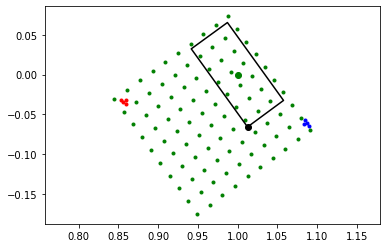

In [26]:
# Moving the CRVAL to (1,0), demo
sip.crval = [1., 0.]
plt.plot(sip.crval[0], sip.crval[1], 'go')
gpx1,gpy1 = petal.focal_mm_to_gfa_pix(petal.gif1.x, petal.gif1.y)
gpx2,gpy2 = petal.focal_mm_to_gfa_pix(petal.gif2.x, petal.gif2.y)
grx,gry = np.meshgrid(np.linspace(x0, x1, 10), np.linspace(y0, y1, 10))
grr,grd = sip.pixelxy2radec(grx,gry)
plt.plot(grr, grd, 'g.')
g1r,g1d = sip.pixelxy2radec(gpx1, gpy1)
g2r,g2d = sip.pixelxy2radec(gpx2, gpy2)
plt.plot(g1r, g1d, 'r.')
plt.plot(g2r, g2d, 'b.')
bra,bdec = sip.pixelxy2radec(petal.ccdbpx, petal.ccdbpy)
plt.plot(bra, bdec, 'k-')
plt.plot(bra[0], bdec[0], 'ko')
plt.axis('equal');

Max arrow length: 6.8 arcsec


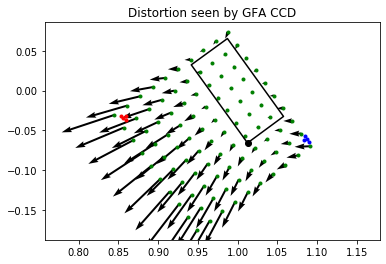

In [30]:
plt.plot(grr, grd, 'g.')
gtr,gtd = sip.wcstan.pixelxy2radec(grx,gry)
plt.quiver(grr, grd, grr-gtr, grd-gtd)
print('Max arrow length: %.1f arcsec' % (np.max(np.hypot(grr-gtr, grd-gtd))*3600.))
plt.plot(g1r, g1d, 'r.')
plt.plot(g2r, g2d, 'b.')
plt.plot(bra, bdec, 'k-')
plt.plot(bra[0], bdec[0], 'ko')
plt.title('Distortion seen by GFA CCD')
plt.axis('equal');

In [34]:
xx = np.linspace(x0, x1, 500)
yy = np.linspace(y0, y1, 500)
r2sip,d2sip = sip.pixelxy2radec(xx, np.zeros_like(xx) + petal.ccdh)
r2tan,d2tan = sip.wcstan.pixelxy2radec(xx, np.zeros_like(xx) + petal.ccdh)
r1sip,d1sip = sip.pixelxy2radec(np.zeros_like(yy) + petal.ccdw, yy)
r1tan,d1tan = sip.wcstan.pixelxy2radec(np.zeros_like(yy) + petal.ccdw, yy)

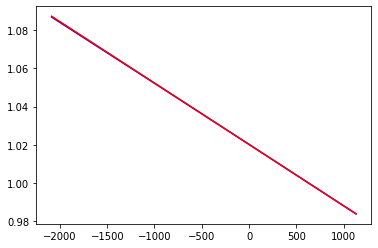

In [35]:
plt.plot(yy, r2sip, 'b-')
plt.plot(yy, r2tan, 'r-');

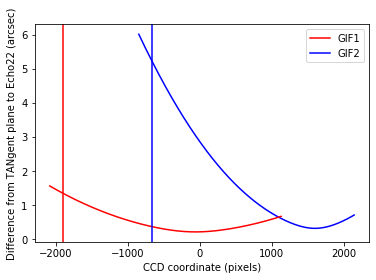

In [38]:
dist1 = np.array([arcsec_between(r1,d1,r2,d2) for r1,d1,r2,d2 in zip(r1sip,d1sip,r1tan,d1tan)])
dist2 = np.array([arcsec_between(r1,d1,r2,d2) for r1,d1,r2,d2 in zip(r2sip,d2sip,r2tan,d2tan)])
plt.plot(xx, dist1, 'b-')
plt.plot(yy, dist2, 'r-');
plt.axvline(gpy1[0], color='r', label='GIF1')
plt.axvline(gpx2[0], color='b', label='GIF2')
plt.legend()
plt.xlabel('CCD coordinate (pixels)')
plt.ylabel('Difference from TANgent plane to Echo22 (arcsec)');

OLD STUFF NOT USED

In [ ]:
from focalplane_ss import focal_surface_ss

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline
rz = np.array([[float(w) for w in line.split('\t')] for line in focal_surface_ss.split('\n')])
Ropt,Zopt = rz[:,0], rz[:,1]
Zoptics = InterpolatedUnivariateSpline(Ropt, Zopt)

In [ ]:
Spoly = np.array([9.95083E-06, 9.99997E-01, 1.79466E-07, 1.76983E-09,
         7.24320E-11, -5.74381E-13, 3.28356E-15, -1.10626E-17,
         1.89154E-20, -1.25367E-23])

In [ ]:
radius = np.linspace(0, 420, 421)
S = np.zeros_like(radius)
for i,s in enumerate(Spoly):
    S += s * radius**i

In [ ]:
# DESI-0530-v16 -- focal plane layout
#device_location_id	device_type	X	Y	Z
design_ss = '''0	POS	28.134375	5.201437	-0.082419
1	POS	38.551296	5.201448	-0.152664
2	POS	33.343493	14.253354	-0.132583
3	POS	48.968106	5.201461	-0.245266
4	POS	43.760371	14.255653	-0.214058
5	POS	59.384810	5.201480	-0.360537
6	POS	54.177144	14.256291	-0.318053
7	POS	48.967142	23.345351	-0.298069
8	POS	69.800289	5.201506	-0.498824
9	POS	64.592763	14.249463	-0.444873
10	POS	59.383858	23.337718	-0.413611
11	FIF	54.182759	32.395574	-0.404797
12	POS	80.215689	5.201540	-0.660539
13	POS	75.008287	14.241437	-0.594928
14	POS	69.800405	23.299254	-0.552079
15	POS	64.599448	32.359504	-0.531959
16	POS	90.630976	5.201583	-0.846101
17	POS	85.423703	14.236912	-0.768639
18	POS	80.215599	23.295915	-0.714161
19	POS	75.016034	32.323704	-0.682426
20	POS	69.786205	41.395803	-0.673227
21	POS	101.046105	5.201632	-1.055932
22	POS	95.838980	14.237022	-0.966431
23	POS	90.630637	23.299708	-0.900149
24	POS	85.432557	32.329622	-0.856874
25	POS	80.200656	41.359380	-0.835814
26	POS	111.461023	5.201688	-1.290443
27	POS	106.254079	14.235969	-1.188700
28	POS	101.045606	23.296309	-1.110389
29	POS	95.848134	32.326855	-1.055354
30	POS	90.614980	41.368525	-1.022718
31	POS	85.361306	50.431334	-1.012965
32	POS	121.875677	5.201751	-1.550013
33	POS	116.668954	14.238986	-1.435858
34	POS	111.460452	23.297031	-1.345338
35	POS	106.263304	32.326987	-1.278351
36	POS	101.029161	41.366600	-1.233845
37	POS	95.776854	50.441734	-1.212562
38	NON	90.539726	59.568980	-1.215569
39	POS	132.290020	5.201820	-1.834975
40	POS	127.083563	14.242436	-1.708249
41	POS	121.875109	23.312745	-1.605420
42	POS	116.677631	32.345810	-1.526342
43	POS	111.443232	41.368033	-1.469701
44	POS	106.192152	50.442824	-1.436591
45	POS	100.955815	59.573706	-1.428027
46	POS	142.704022	5.201895	-2.145600
47	POS	137.497877	14.241743	-2.006158
48	POS	132.289546	23.328109	-1.890884
49	POS	127.093215	32.371519	-1.799643
50	POS	121.857174	41.401574	-1.730894
51	POS	116.607190	50.444640	-1.685510
52	POS	111.371701	59.574862	-1.665163
53	POS	106.147709	68.622231	-1.667694
54	POS	153.117665	5.201978	-2.482086
55	POS	147.911879	14.235958	-2.329817
56	POS	142.703742	23.330238	-2.201928
57	POS	137.506269	32.376499	-2.098242
58	POS	132.271120	41.413641	-2.017254
59	POS	127.021981	50.454549	-1.959713
60	POS	121.787408	59.563824	-1.927184
61	POS	116.563412	68.623975	-1.918115
62	POS	163.530944	5.202069	-2.844554
63	POS	158.325567	14.241167	-2.679433
64	POS	153.117660	23.321177	-2.538751
65	POS	147.918667	32.352849	-2.422347
66	POS	142.685037	41.415900	-2.329129
67	POS	137.436514	50.486772	-2.259620
68	POS	132.202886	59.588974	-2.214985
69	POS	126.978911	68.612156	-2.193495
70	POS	121.778363	77.687710	-2.197208
71	POS	173.943870	5.202169	-3.233037
72	POS	168.738956	14.240451	-3.055031
73	POS	163.531281	23.302369	-2.901472
74	POS	158.330800	32.347757	-2.772446
75	FIF	153.098887	41.393265	-2.666555
76	POS	147.850932	50.487573	-2.584842
77	POS	142.618180	59.596960	-2.528094
78	POS	137.394166	68.637151	-2.494814
79	POS	132.194081	77.680593	-2.486192
80	POS	184.356463	5.202278	-3.647476
81	POS	179.152070	14.237881	-3.456608
82	POS	173.944624	23.313286	-3.290323
83	POS	168.742846	32.358998	-3.148597
84	POS	163.512702	41.389721	-3.030031
85	POS	158.265131	50.453724	-2.935460
86	POS	153.033251	59.588635	-2.866668
87	POS	147.809242	68.640326	-2.821366
88	POS	142.609571	77.685414	-2.800809
89	POS	137.409794	86.716472	-2.803969
90	POS	194.768763	5.202397	-4.087734
91	POS	189.564948	14.231336	-3.884058
92	POS	184.357651	23.280410	-3.704860
93	POS	179.154623	32.342155	-3.550453
94	POS	173.926432	41.409409	-3.419611
95	POS	168.679209	50.459776	-3.312354
96	POS	163.448048	59.556355	-3.230675
97	POS	158.224107	68.634312	-3.173432
98	POS	153.024816	77.664324	-3.140525
99	POS	147.825218	86.706198	-3.131882
100	POS	142.616722	95.751246	-3.147111
101	POS	205.180829	5.202527	-4.553598
102	POS	199.977654	14.228149	-4.337229
103	POS	194.770456	23.256961	-4.145219
104	POS	189.566012	32.307850	-3.977977
105	POS	184.340094	41.387352	-3.834629
106	POS	179.093132	50.462417	-3.715005
107	POS	173.862650	59.551524	-3.620789
108	POS	168.638734	68.605303	-3.550822
109	POS	163.439840	77.654626	-3.506024
110	POS	158.240184	86.685466	-3.485072
111	POS	153.031586	95.726599	-3.488175
112	POS	215.592744	5.202667	-5.044797
113	POS	210.390253	14.233781	-4.815894
114	POS	205.183093	23.257197	-4.611264
115	POS	199.977245	32.285080	-4.431206
116	POS	194.753631	41.348039	-4.275158
117	POS	189.506912	50.462612	-4.143312
118	POS	184.277019	59.546670	-4.036566
119	POS	179.053197	68.607518	-3.954311
120	POS	173.854426	77.638308	-3.896961
121	POS	168.655095	86.670127	-3.863853
122	POS	163.446281	95.705959	-3.854716
123	POS	158.248634	104.741309	-3.870224
124	POS	226.004616	5.202820	-5.561013
125	POS	220.802775	14.229185	-5.319695
126	POS	215.595622	23.261744	-5.102621
127	POS	210.388311	32.317634	-4.910212
128	POS	205.167155	41.341782	-4.741456
129	POS	199.920516	50.426528	-4.596705
130	POS	194.691621	59.521908	-4.477607
131	POS	189.467524	68.577093	-4.382801
132	POS	184.268924	77.622912	-4.313382
133	POS	179.069504	86.655195	-4.268042
134	POS	173.860831	95.690899	-4.246718
135	POS	168.663659	104.721625	-4.250040
136	POS	236.416418	5.202984	-6.101909
137	POS	231.215143	14.228888	-5.848342
138	POS	226.008091	23.252494	-5.618881
139	POS	220.799357	32.296346	-5.413915
140	POS	215.580565	41.367331	-5.233235
141	POS	210.334018	50.389100	-5.075337
142	POS	205.105538	59.491820	-4.943851
143	POS	199.882451	68.552724	-4.836730
144	POS	194.682930	77.592933	-4.754841
145	POS	189.483958	86.638469	-4.697482
146	POS	184.275264	95.675817	-4.663955
147	POS	179.078456	104.707107	-4.655151
148	POS	173.885775	113.739788	-4.670876
149	POS	246.838139	5.203163	-6.667712
150	FIF	241.627317	14.223609	-6.401469
151	POS	236.420299	23.253682	-6.159827
152	POS	231.210442	32.278714	-5.942410
153	POS	225.994948	41.335119	-5.749412
154	POS	220.747479	50.412015	-5.579621
155	POS	215.519290	59.455303	-5.435037
156	POS	210.296516	68.523290	-5.315623
157	POS	205.096945	77.569992	-5.221518
158	POS	199.897878	86.608920	-5.151744
159	POS	194.689627	95.659188	-5.106229
160	POS	189.493000	104.691658	-5.085266
161	POS	184.300546	113.724981	-5.088871
162	POS	179.106358	122.756412	-5.116722
163	POS	257.252581	5.203355	-7.257219
164	POS	252.044444	14.225931	-6.979102
165	POS	246.832142	23.247567	-6.725043
166	POS	241.621641	32.280091	-6.495493
167	POS	236.409626	41.304861	-6.290191
168	POS	231.161858	50.379780	-6.107991
169	POS	225.932910	59.445972	-5.951322
170	POS	220.710026	68.489860	-5.819230
171	POS	215.510811	77.540650	-5.712918
172	POS	210.312055	86.586048	-5.631009
173	POS	205.104645	95.629603	-5.573119
174	POS	199.907269	104.672739	-5.540138
175	POS	194.715187	113.707386	-5.531610
176	POS	189.520745	122.739141	-5.547294
177	POS	267.667769	5.203564	-7.870659
178	POS	262.457076	14.223228	-7.580439
179	POS	257.245228	23.248210	-7.314422
180	POS	252.034981	32.272538	-7.072788
181	POS	246.822518	41.305017	-6.855427
182	POS	241.576687	50.349591	-6.660775
183	POS	236.347185	59.413428	-6.491778
184	POS	231.128043	68.474233	-6.347859
185	POS	225.924551	77.507637	-6.228817
186	POS	220.726030	86.556806	-6.134746
187	POS	215.518882	95.606560	-6.064743
188	POS	210.321473	104.643918	-6.019405
189	POS	205.129745	113.686869	-5.998894
190	POS	199.935558	122.719129	-6.002410
191	POS	194.744335	131.752958	-6.030497
192	POS	278.094967	5.203789	-8.508655
193	POS	272.880840	14.222591	-8.206283
194	POS	267.662804	23.247127	-7.927934
195	POS	262.450433	32.272277	-7.674202
196	POS	257.238503	41.294646	-7.444760
197	POS	251.993690	50.347747	-7.238108
198	POS	246.762246	59.383505	-7.056492
199	POS	241.542032	68.441362	-6.900271
200	POS	236.339412	77.492988	-6.769400
201	POS	231.139839	86.523335	-6.662744
202	POS	225.930951	95.573444	-6.580426
203	POS	220.735635	104.618025	-6.523143
204	POS	215.544261	113.658685	-6.490394
205	POS	210.350327	122.700956	-6.481986
206	POS	205.159459	131.735505	-6.497923
207	POS	288.520497	5.204032	-9.170480
208	POS	283.299843	14.229781	-8.855715
209	POS	278.079780	23.248036	-8.565241
210	POS	272.860653	32.273705	-8.299135
211	POS	267.649767	41.298301	-8.057807
212	POS	262.411205	50.331000	-7.839225
213	POS	257.182799	59.378796	-7.645829
214	POS	251.957037	68.411117	-7.476803
215	POS	246.753235	77.459791	-7.333682
216	POS	241.554656	86.509371	-7.215298
217	POS	236.346852	95.544478	-7.120554
218	POS	231.149812	104.586756	-7.050948
219	POS	225.958811	113.631634	-7.006136
220	POS	220.765092	122.670975	-6.985460
221	POS	215.574184	131.715951	-6.989494
222	POS	210.382581	140.750850	-7.017600
223	POS	298.953468	5.204294	-9.857001
224	POS	293.728561	14.218382	-9.529742
225	POS	288.505535	23.257544	-9.227068
226	POS	283.281475	32.275235	-8.948564
227	POS	278.067188	41.301079	-8.695034
228	POS	272.827144	50.336734	-8.464336
229	POS	267.600450	59.355858	-8.258622
230	POS	262.380923	68.406696	-8.078133
231	POS	257.168712	77.430867	-7.922044
232	POS	251.967640	86.476933	-7.791341
233	POS	246.762098	95.530283	-7.684954
234	POS	241.563171	104.560869	-7.602848
235	POS	236.373441	113.597456	-7.545742
236	POS	231.179947	122.643407	-7.513065
237	POS	225.989315	131.685151	-7.504825
238	POS	220.798536	140.727742	-7.521000
239	FIF	215.603297	149.762750	-7.561100
240	POS	309.394888	5.204578	-10.568833
241	POS	304.165392	14.217045	-10.228797
242	POS	298.933687	23.243163	-9.913162
243	POS	293.710750	32.275395	-9.622605
244	POS	288.488660	41.300648	-9.356448
245	POS	283.262855	50.323803	-9.114380
246	POS	278.029621	59.359249	-8.896349
247	POS	272.801211	68.375285	-8.702714
248	POS	267.589952	77.423349	-8.534976
249	POS	262.380822	86.446658	-8.391294
250	POS	257.175223	95.496859	-8.272705
251	POS	251.987934	104.541895	-8.179454
252	POS	246.787326	113.571952	-8.109454
253	POS	241.594950	122.609516	-8.064452
254	POS	236.404576	131.653657	-8.044111
255	POS	231.216804	140.694437	-8.048185
256	POS	226.028648	149.734666	-8.076585
257	POS	319.850121	5.204885	-11.307161
258	POS	314.612103	14.217002	-10.953653
259	POS	309.378502	23.237608	-10.625208
260	POS	304.147696	32.261157	-10.321578
261	POS	298.923722	41.293825	-10.043004
262	POS	293.694739	50.321298	-9.788509
263	POS	288.474419	59.345236	-9.558944
264	POS	283.240527	68.372772	-9.352929
265	POS	278.012139	77.388951	-9.171448
266	POS	272.809994	86.429959	-9.016376
267	POS	267.593405	95.455660	-8.884476
268	POS	262.401352	104.508495	-8.778994
269	POS	257.211709	113.548234	-8.697715
270	POS	252.014008	122.580228	-8.640111
271	POS	246.820044	131.619729	-8.607269
272	POS	241.633103	140.662841	-8.599280
273	POS	236.444935	149.703018	-8.615484
274	POS	231.256874	158.743266	-8.656044
275	POS	330.318532	5.205216	-12.073034
276	POS	325.078996	14.216518	-11.705999
277	POS	319.828921	23.235072	-11.363253
278	POS	314.595961	32.254673	-11.046598
279	POS	309.365682	41.280926	-10.754879
280	POS	304.135730	50.314371	-10.487863
281	POS	298.912497	59.340436	-10.245747
282	POS	293.686595	68.356517	-10.027751
283	POS	288.459291	77.376609	-9.834108
284	POS	283.236538	86.392020	-9.665035
285	POS	278.024213	95.437310	-9.521578
286	POS	272.821097	104.465024	-9.402689
287	POS	267.630443	113.512587	-9.309372
288	POS	262.441442	122.550130	-9.240250
289	POS	257.245276	131.585800	-9.194988
290	POS	252.057751	140.623250	-9.174607
291	POS	246.867458	149.670397	-9.178725
292	POS	241.677540	158.713293	-9.207083
293	POS	340.797188	5.205575	-12.867597
294	POS	335.552207	14.218306	-12.486083
295	POS	330.298035	23.224970	-12.129266
296	POS	325.054239	32.249735	-11.798497
297	POS	319.819860	41.272437	-11.493384
298	POS	314.589074	50.294871	-11.213326
299	POS	309.371478	59.320811	-10.958902
300	POS	304.150100	68.340233	-10.728680
301	POS	298.925421	77.362295	-10.522758
302	POS	293.676715	86.384136	-10.339693
303	POS	288.453718	95.402776	-10.182688
304	POS	283.254608	104.435641	-10.051900
305	POS	278.057515	113.471479	-9.945668
306	POS	272.870897	122.512376	-9.864567
307	POS	267.682215	131.551279	-9.807628
308	POS	262.490887	140.589317	-9.774842
309	POS	257.291318	149.636802	-9.766236
310	POS	252.099270	158.687269	-9.782557
311	POS	246.917324	167.729911	-9.823532
312	POS	351.280618	5.205963	-13.691992
313	POS	346.034733	14.214559	-13.295560
314	POS	340.778866	23.232078	-12.924261
315	POS	335.530289	32.234896	-12.579013
316	POS	330.285806	41.261496	-12.259553
317	POS	325.050884	50.288478	-11.965927
318	POS	319.828324	59.302608	-11.697953
319	POS	314.601034	68.336209	-11.454655
320	POS	309.373021	77.352030	-11.235694
321	FIF	304.144678	86.373300	-11.041361
322	POS	298.918599	95.390299	-10.871596
323	POS	293.697158	104.410906	-10.726660
324	POS	288.499421	113.443777	-10.607980
325	POS	283.304821	122.479109	-10.513948
326	POS	278.114386	131.526696	-10.444905
327	POS	272.923365	140.568834	-10.400054
328	POS	267.728162	149.605054	-10.379125
329	POS	262.526411	158.657932	-10.382758
330	POS	257.345257	167.706617	-10.411861
331	NON	252.162106	176.750314	-10.465030
332	POS	361.783127	5.206384	-14.549105
333	POS	356.530930	14.220045	-14.136500
334	POS	351.271491	23.232906	-13.749722
335	POS	346.019309	32.245241	-13.389574
336	POS	340.768571	41.247595	-13.055163
337	POS	335.525469	50.277241	-12.747047
338	POS	330.294391	59.301199	-12.465020
339	POS	325.070982	68.316073	-12.208444
340	POS	319.851287	77.335954	-11.977046
341	POS	314.623303	86.355671	-11.769773
342	POS	309.393767	95.374515	-11.587014
343	POS	304.167566	104.400012	-11.429209
344	POS	298.948599	113.421707	-11.296325
345	POS	293.750911	122.455935	-11.189651
346	POS	288.553193	131.494549	-11.107533
347	POS	283.363186	140.541106	-11.050585
348	POS	278.169146	149.589855	-11.017886
349	POS	272.969703	158.626925	-11.008879
350	POS	267.784582	167.675147	-11.025557
351	POS	262.605756	176.725473	-11.067107
352	POS	372.304572	5.206842	-15.440826
353	POS	367.046904	14.222657	-15.011204
354	POS	361.784479	23.239621	-14.608186
355	POS	356.519189	32.251191	-14.231495
356	POS	351.267336	41.266855	-13.882142
357	POS	346.014080	50.267603	-13.558386
358	POS	340.775422	59.295836	-13.261679
359	POS	335.555016	68.318525	-12.991660
360	POS	330.326002	77.329411	-12.745911
361	POS	325.099923	86.353919	-12.525580
362	POS	319.868254	95.368418	-12.329484
363	POS	314.637249	104.387907	-12.158275
364	POS	309.427165	113.415438	-12.013390
365	POS	304.208643	122.438262	-11.892373
366	POS	299.007270	131.474777	-11.797446
367	POS	293.812414	140.513049	-11.727514
368	POS	288.618081	149.564277	-11.682528
369	POS	283.434521	158.608349	-11.662486
370	POS	278.235112	167.644897	-11.665619
371	POS	273.048024	176.699716	-11.694696
372	POS	267.869980	185.752885	-11.748763
373	POS	382.851708	5.207341	-16.369647
374	POS	377.581275	14.225697	-15.921480
375	POS	372.310360	23.245507	-15.500886
376	POS	367.036487	32.265703	-15.107224
377	POS	361.774214	41.273042	-14.741197
378	POS	356.521510	50.285321	-14.402351
379	POS	351.271943	59.289571	-14.089663
380	POS	346.050117	68.310962	-13.805129
381	POS	340.826055	77.330498	-13.545841
382	POS	335.598169	86.342713	-13.311368
383	POS	330.367518	95.360056	-13.101863
384	POS	325.135653	104.372163	-12.917097
385	POS	319.908601	113.396362	-12.757811
386	POS	314.691225	122.433475	-12.624339
387	POS	309.471704	131.456899	-12.515035
388	POS	304.271509	140.492776	-12.432075
389	POS	299.077457	149.538764	-12.374455
390	POS	293.895890	158.584419	-12.342237
391	POS	288.714729	167.629767	-12.334575
392	POS	283.515091	176.664566	-12.349843
393	POS	278.343637	185.717251	-12.392174
394	POS	393.424937	5.207884	-17.337325
395	POS	388.140778	14.229285	-16.869737
396	POS	382.863296	23.247053	-16.430889
397	POS	377.591794	32.264029	-16.020274
398	POS	372.323203	41.277959	-15.637166
399	POS	367.059580	50.285702	-15.281291
400	POS	361.805862	59.294163	-14.952744
401	POS	356.557594	68.302202	-14.650789
402	POS	351.332946	77.326055	-14.376874
403	POS	346.106481	86.351068	-14.128452
404	POS	340.874021	95.367865	-13.904804
405	POS	335.640990	104.385298	-13.706357
406	POS	330.406184	113.397881	-13.532738
407	POS	325.172714	122.420562	-13.384453
408	POS	319.951289	131.457285	-13.262356
409	POS	314.740071	140.488302	-13.165650
410	POS	309.544573	149.527366	-13.095060
411	POS	304.359611	158.566940	-13.049907
412	POS	299.178985	167.613923	-13.029974
413	POS	293.998533	176.660957	-13.034708
414	POS	288.801639	185.695643	-13.062499
415	POS	283.637442	194.747780	-13.117824
416	POS	404.081201	5.208477	-18.350559
417	POS	398.738956	14.225389	-17.858705
418	POS	393.449077	23.249638	-17.400470
419	POS	388.167805	32.268975	-16.971185
420	POS	382.890716	41.283512	-16.570017
421	POS	377.618145	50.294466	-16.196593
422	POS	372.348713	59.303226	-15.850413
423	POS	367.092929	68.311732	-15.532043
424	POS	361.850852	77.323843	-15.241188
425	POS	356.626281	86.349467	-14.978049
426	POS	351.396985	95.375716	-14.740313
427	POS	346.159685	104.396074	-14.527379
428	POS	340.921924	113.416595	-14.339816
429	POS	335.673666	122.435172	-14.176645
430	POS	330.441604	131.452755	-14.039819
431	POS	325.231465	140.491382	-13.930301
432	POS	320.024196	149.522514	-13.845693
433	POS	314.833968	158.562743	-13.787499
434	POS	309.652699	167.606302	-13.754882
435	POS	304.467332	176.653076	-13.746898
436	POS	299.297680	185.703512	-13.764947
437	POS	294.103927	194.734795	-13.805322
438	NON	288.953309	203.790235	-13.874466
439	FIF	409.474266	14.197003	-18.898949
440	POS	404.122544	23.218728	-18.415962
441	POS	398.819158	32.244354	-17.966249
442	POS	393.534784	41.265881	-17.546494
443	POS	388.254349	50.281413	-17.154860
444	POS	382.975029	59.289875	-16.790698
445	POS	377.695835	68.298438	-16.453664
446	POS	372.431600	77.312536	-16.144837
447	POS	367.188181	86.331367	-15.864379
448	POS	361.959983	95.356349	-15.611525
449	POS	356.724409	104.385028	-15.384085
450	POS	351.492977	113.402714	-15.182459
451	POS	346.256488	122.421077	-15.005980
452	POS	341.024728	131.441075	-14.855323
453	POS	335.785391	140.454435	-14.729134
454	POS	330.586206	149.495602	-14.632116
455	POS	325.380123	158.528685	-14.559383
456	POS	320.190631	167.570784	-14.513241
457	POS	315.006255	176.615530	-14.492562
458	POS	309.825442	185.662528	-14.497202
459	POS	304.656415	194.714323	-14.527854
460	NON	299.461566	203.749679	-14.580945
461	ETC	409.459957	32.248592	-18.998638
462	POS	404.147873	41.278355	-18.558247
463	POS	398.858533	50.299485	-18.148110
464	POS	393.573850	59.315593	-17.766165
465	POS	388.290327	68.325855	-17.411751
466	POS	383.007996	77.333682	-17.084608
467	POS	377.741454	86.343664	-16.785829
468	POS	372.508215	95.364327	-16.516812
469	POS	367.283208	104.387676	-16.274875
470	POS	362.050127	113.406552	-16.058209
471	POS	356.818155	122.425394	-15.867516
472	POS	351.580840	131.442079	-15.702025
473	POS	346.344975	140.462498	-15.562338
474	POS	341.111212	149.483456	-15.448292
475	POS	335.907947	158.521088	-15.362587
476	POS	330.709526	167.562969	-15.302688
477	POS	325.519300	176.606974	-15.268721
478	NON	320.337006	185.652998	-15.260616
479	NON	315.158929	194.701275	-15.278089
480	NON	309.989652	203.755799	-15.321672
481	NON	304.801298	212.798938	-15.388569
482	FIF	404.225409	59.321591	-18.784086
483	POS	398.935554	68.338881	-18.411840
484	POS	393.644277	77.349185	-18.066866
485	POS	388.358798	86.355441	-17.749620
486	POS	383.089415	95.372899	-17.461089
487	POS	377.852793	104.397078	-17.202413
488	POS	372.624629	113.420212	-16.970917
489	POS	367.386042	122.443874	-16.764765
490	POS	362.154678	131.464561	-16.585215
491	POS	356.909760	140.486544	-16.430457
492	POS	351.668982	149.510741	-16.301908
493	POS	346.435663	158.528282	-16.199388
494	POS	341.232939	167.564785	-16.125586
495	POS	336.040651	176.610884	-16.078466
496	FIF	330.848478	185.657667	-16.056824
497	NON	325.667527	194.706751	-16.061564
498	NON	320.491841	203.758362	-16.092228
499	NON	315.326169	212.817798	-16.149454
500	NON	404.312382	77.368452	-19.089997
501	ETC	399.011224	86.384671	-18.754597
502	POS	393.721763	95.393281	-18.447464
503	POS	388.443108	104.409809	-18.168602
504	POS	383.204612	113.440147	-17.920656
505	POS	377.954604	122.477680	-17.698495
506	POS	372.712972	131.501382	-17.503138
507	POS	367.484156	140.523431	-17.335089
508	POS	362.238745	149.545467	-17.191674
509	POS	357.000577	158.568158	-17.074874
510	POS	351.768135	167.583942	-16.984134
511	POS	346.569076	176.623367	-16.922842
512	POS	341.374433	185.674350	-16.888103
513	NON	336.188661	194.721628	-16.879595
514	NON	331.012369	203.769815	-16.897523
515	NON	325.846164	212.829023	-16.942429
516	NON	320.686786	221.887768	-17.013540
517	FIF	393.926712	113.390039	-18.918818
518	POS	388.652210	122.444328	-18.678902
519	POS	383.386290	131.492023	-18.466484
520	POS	378.135810	140.515642	-18.281365
521	POS	372.908118	149.543582	-18.124855
522	POS	367.654716	158.566307	-17.992142
523	POS	362.419686	167.587405	-17.887145
524	POS	357.190057	176.613581	-17.808869
525	POS	351.991106	185.657962	-17.759959
526	POS	346.797988	194.710169	-17.737838
527	NON	341.616862	203.760230	-17.742532
528	NON	336.441256	212.812569	-17.773693
529	NON	331.277862	221.875049	-17.832287
530	NON	326.068172	230.969235	-17.915023
531	NON	383.551879	149.556603	-19.092997
532	OPT	378.312514	158.597059	-18.947493
533	OPT	373.055789	167.618750	-18.826166
534	FIF	367.822967	176.645359	-18.733541
535	NON	362.597006	185.675302	-18.667928
536	NON	357.397057	194.719958	-18.631448
537	NON	352.205528	203.771149	-18.622179
538	NON	347.032787	212.829122	-18.641002
539	NON	341.854447	221.889013	-18.685643
540	NON	336.655826	230.974664	-18.756303
541	GIF	295.568779	207.451460	-14.494325
542	GIF	357.223911	202.680763	-19.097053
543	TB0	23.104558	12.080089	-81.920000
544	TB1	425.250167	25.264515	-102.920000
545	TB2	390.667592	169.867103	-102.920000'''

In [ ]:
def parse_design_ss(ss):
    design = []
    for line in ss.split('\n'):
        words = line.split('\t')
        design.append((words[1], float(words[2]), float(words[3]), float(words[4])))
    return design

In [ ]:
design = parse_design_ss(design_ss)
D = fits_table()
D.device = np.array([d[0] for d in design])
D.x = np.array([d[1] for d in design])
D.y = np.array([d[2] for d in design])
D.z = np.array([d[3] for d in design])
# Drop tooling balls
D = D[np.array([not(d.startswith('TB')) for d in D.device])]

In [ ]:
plt.scatter(D.x, D.y, c=D.z, s=1);
#plt.colorbar()
plt.scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], edgecolors='k');
plt.axis('equal');

In [ ]:
plt.plot(tp[:,0], tp[:,1], 'k.', label='POS')

In [ ]:
plt.figure(figsize=(8,8))
plt.clf()
plt.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)

P = D[D.device == 'POS']
vp = np.vstack((P.x, P.y)).T
tp = np.dot(R, (vp-vc).T).T + pc

# gfa size (mountain)
h,w = 1032, 2048
pixx = np.array([1, 1, w, w, 1])
pixy = np.array([1, h, h, 1, 1])
ccdx = t.mm_x_coeffs[0] + t.mm_x_coeffs[1]*pixx + t.mm_x_coeffs[2]*pixy
ccdy = t.mm_y_coeffs[0] + t.mm_y_coeffs[1]*pixx + t.mm_y_coeffs[2]*pixy

plt.plot(ph[:,0], ph[:,1], 'ro', label='GIF1')
plt.plot(pi[:,0], pi[:,1], 'co', label='GIF2')
plt.plot(th[:,0], th[:,1], 'kx', label='FIF');
plt.plot(tp[:,0], tp[:,1], 'k.', label='POS')
plt.plot(ccdx, ccdy, 'b-', label='GFA CCD bounds')
plt.legend()
plt.axis('equal');
plt.xlabel('"x" (mm)')
plt.ylabel('"y" (mm)')
plt.title('GFA/GIF/FIF tiedown, petal 4')
plt.savefig('/tmp/1.png')